In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['JAX_PLATFORM_NAME']='cpu'
import sys
sys.path.append('/home/xmax/projects/nn_ansatz/src')

import jax
from jax.tree_util import tree_flatten
from jax.experimental.optimizers import adam
import jax.numpy as jnp
from jax import lax

import numpy as np
from tqdm.notebook import trange

import matplotlib.pyplot as plt
from matplotlib import cm

from nn_ansatz import *


/home/xmax/anaconda3/envs/drop/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
walkers = load_pk('./walkers_no_infs.pk')
datasets = {}

In [ ]:
# COMPARING N SINES

for i in range(1, 4):
    cfg = setup(system='LiSolid', n_periodic_input = i, name='sin%i' % i)
    logger = run_vmc(cfg, walkers=walkers)
    datasets['sin%i' % i] = logger.data


In [ ]:
# SCALAR INPUTS

cfg = setup(system='LiSolid', scalar_inputs = True, name='scalar_inputs')
logger = run_vmc(cfg, walkers=walkers)
datasets['scalar_data'] = logger.data

In [ ]:
# DIFFERENT SIZE NETWORKS

ss = [16, 32, 64]
ps = [8, 16, 16]
ds = [2, 4, 8]

ss = [64]
ps = [16]
ds = [8]
for s, p, d in zip(ss, ps, ds):
    name = 'sh%i_ph%i_det%i_sin2' % (s, p, d)
    cfg = setup(system='LiSolid', n_periodic_input = 2, name=name, n_sh=s, n_ph=p, n_det=d, save_every=1000, n_it=1001)
    logger = run_vmc(cfg, walkers=walkers)
    datasets[name] = logger.data

In [45]:
save_pk(datasets, './plotting_data_tmp.pk')

In [ ]:
path = '/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/sh64_ph16_det8_sin2/kfac_1lr-4_1d-3_1nc-4_m512_s64_p16_l2_det8/run2'
cfg = load_config_pk(os.path.join(path, 'config1.pk'))
mol = SystemAnsatz(**cfg)
swf = create_wf(mol, signed=True)
vwf = create_wf(mol)
params = load_pk(os.path.join(path, 'models', 'i1000.pk'))
jswf = jit(swf)
compute_energy = create_energy_fn(mol, vwf, separate=True)

In [3]:
def plot_references(mol, ax, method, ref, ymax=10, ymin=-10):
    rx0, ry0, rz0 = mol.r_atoms[0]
    mcw = mol.min_cell_width
    n_samples = 10000
    ucw = mol.unit_cell_length
    width = mcw
    y_line = np.linspace(ymin, ymax, 100)
    ax.plot([rx0 for _ in y_line], y_line, color='r', ls='--', label='nucleus')
    if ref[0]:
        ax.plot([ref[1] for _ in y_line], y_line, color='g', ls='--', label=method)
    ax.plot([rx0-mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')
    ax.plot([rx0+mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')

    ax.plot([rx0-mcw/4. for _ in y_line], y_line, color='orange', ls='--', label='orbital_boundary /2.')
    ax.plot([rx0+mcw/4. for _ in y_line], y_line, color='orange', ls='--', label='orbital_boundary /2.')

    ax.plot([rx0-ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')
    ax.plot([rx0+ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')


def generate_positions(mol, method='random'):
    rx0, ry0, rz0 = mol.r_atoms[0]
    x1, x2, x3 = [float(np.random.uniform(rx0 - 1, rx0 + 1)) for i in range(3)]
    y1, y2, y3 = [float(np.random.uniform(ry0 - 1, ry0 + 1)) for i in range(3)]
    z1, z2, z3 = [float(np.random.uniform(rz0 - 1, rz0 + 1)) for i in range(3)]
    if method == 'random':
        return (x1, x2, x3), (ry0, y2, y3), (rz0, z2, z3), (False, 0.0)
    if method == 'up_in_line':
        x2 = rx0 - 0.75
        return (x1, x2, x3), (ry0, ry0, y3), (rz0, rz0, z3), (True, x2)
    if method == 'down_in_line':
        x3 = rx0 - 0.75
        return (x1, x2, x3), (ry0, y2, ry0), (rz0, z2, rz0), (True, x3)




def plot_amps_and_energies(mol, data, ref, exp, lim):
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs = [x for y in axs for x in y]
    names = ['amps', 'local_e', 'potential_e', 'kinetic_e']
    X = data['x']
    for ax, name in zip(axs, names):
        y = data[name]
        ax.plot(X, y)
        y = np.clip(y, -lim, lim)
        ymax, ymin = np.nanmax(y), np.nanmin(y)
        plot_references(mol, ax, name, ref, ymax=ymax, ymin=ymin)
        ax.set_ylabel(name)
        ax.set_xlabel('x_displacement')
        ax.set_ylim(ymin, ymax)

    axs[-1].legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.suptitle('%s' % exp)
    fig.tight_layout()



def get_amps_and_energy(path, method):
    cfg = load_config_pk(os.path.join(path, 'config1.pk'))
    mol = SystemAnsatz(**cfg)
    swf = create_wf(mol, signed=True)
    vwf = create_wf(mol)
    params = load_pk(os.path.join(path, 'models', 'i1000.pk'))
    jswf = jit(swf)
    compute_energy = create_energy_fn(mol, vwf, separate=True)
    (_, x2, x3), (y1, y2, y3), (z1, z2, z3), ref = generate_positions(mol, method=method)  # ref contains the details of ref electron
    mcw = mol.min_cell_width
    n_samples = 10000
    width = mcw
    rx0, ry0, rz0 = mol.r_atoms[0]
    X = np.linspace(-width+rx0, width+rx0, n_samples)

    data = []
    for x1 in X:
        walker = jnp.array([[[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]]])

        walker = keep_in_boundary(walker, mol.real_basis, mol.inv_real_basis)
        log_psi, sign = jswf(params, walker)
        amplitude = sign * jnp.exp(log_psi)
        probability = amplitude**2
        
        pe, ke = compute_energy(params, walker)
        local_energy = pe + ke
        tmp = [x1, amplitude.mean(), probability.mean(), local_energy.mean(), pe.mean(), ke.mean()]
        data.append(tmp)

    data = np.array(data)
    data = pd.DataFrame(data, columns=['x', 'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e'])

    return data, ref, mol


In [3]:
od_datasets = {}

In [6]:
# DIFFERENT ORBITALS

orbitalss = ['anisotropic']
systems = ['LiSolid']
for od in orbitalss:
    for system in systems:
        for i in range(2, 3):
            name = '%s_%s_%s' % (od, 'sin%i' % i, 'unitcube_stopgradminim')
            cfg = setup(system=system, orbitals=od, n_it=1001, name=name, n_periodic_input=i)
            logger = run_vmc(cfg)
            od_datasets[name] = logger.data


version 		 070721
seed 		 369
n_devices 		 1
save_every 		 1000
print_every 		 100
exp_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/070721/anisotropic_sin2_unitcube/kfac_1lr-4_1d-3_1nc-4_m512_s32_p8_l2_det2/run2
events_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/070721/anisotropic_sin2_unitcube/kfac_1lr-4_1d-3_1nc-4_m512_s32_p8_l2_det2/run2/events
models_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/070721/anisotropic_sin2_unitcube/kfac_1lr-4_1d-3_1nc-4_m512_s32_p8_l2_det2/run2/models
opt_state_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/070721/anisotropic_sin2_unitcube/kfac_1lr-4_1d-3_1nc-4_m512_s32_p8_l2_det2/run2/models/opt_state
pre_path 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/pretrained/s32_p8_l2_det2_1lr-4_i1000.pk
timing_dir 		 /home/xmax/projects/nn_ansat

training:   0%|          | 1/1002 [00:00<?, ?it/s]

step 100 | e_mean -1.5363 | e_std 2.2126 | e_mean_mean -1.5455 | acceptance 0.8084 | t_per_it 0.3367 |
step 200 | e_mean -2.7481 | e_std 24.0165 | e_mean_mean -1.8259 | acceptance 0.6822 | t_per_it 0.3343 |
step 300 | e_mean -1.7929 | e_std 2.0220 | e_mean_mean -1.8445 | acceptance 0.5650 | t_per_it 0.3358 |
step 400 | e_mean -1.9637 | e_std 1.8125 | e_mean_mean -1.9411 | acceptance 0.4996 | t_per_it 0.3408 |
step 500 | e_mean -2.0111 | e_std 1.5749 | e_mean_mean -2.0260 | acceptance 0.5055 | t_per_it 0.3447 |
step 600 | e_mean -2.0907 | e_std 1.7865 | e_mean_mean -2.0683 | acceptance 0.4926 | t_per_it 0.3482 |
step 700 | e_mean -2.1990 | e_std 1.6125 | e_mean_mean -2.1601 | acceptance 0.4998 | t_per_it 0.3484 |
step 800 | e_mean -2.1650 | e_std 2.0847 | e_mean_mean -2.2156 | acceptance 0.4861 | t_per_it 0.3508 |
step 900 | e_mean -2.2753 | e_std 1.5756 | e_mean_mean -2.2637 | acceptance 0.4980 | t_per_it 0.3517 |
step 1000 | e_mean -2.4172 | e_std 1.5752 | e_mean_mean -2.3328 | accept

In [27]:
save_data = {}

In [28]:
# randome 
# e_up in line
# e_down in line
lim = 50
base_path = '/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid'
exps = ['anisotropic_wtransform', 'isotropic', 'anisotropic']

for exp in exps:
    path = os.path.join(base_path, exp + '/kfac_1lr-4_1d-3_1nc-4_m512_s32_p8_l2_det2/run0')
    methods = ['random', 'up_in_line', 'down_in_line']
    final_e = od_datasets[exp]['e_mean_mean'][-1]
    for method in methods:
        data, ref, mol = get_amps_and_energy(path, method)
        save_data['%s_%s' % (exp, method)] = data

System: 
 n_atoms = 1 
 n_up    = 2 
 n_down  = 1 
 n_el    = 3 

Ansatz: 
 n_layers = 2 
 n_det    = 2 
 n_sh     = 32 
 n_ph     = 8 

Cell: 
 real_basis: 
 [[ 5.6081324  0.         0.       ]
 [-1.8693775  5.287398   0.       ]
 [-1.8693775 -2.6436992  4.5790205]] 
 reciprocal_basis: 
 [[ 1.1203705   0.39611074  0.6860841 ]
 [-0.          1.1883323   0.6860841 ]
 [ 0.         -0.          1.3721681 ]] 
 real_cut         = 6.00 
 reciprocal_cut   = 6 
 kappa            = 0.50 
 volume           = 135.78 
 min_cell_width   = 4.58 
 n_periodic_input = 1 

converged SCF energy = -7.31552598128109
creating wf
creating wf
System: 
 n_atoms = 1 
 n_up    = 2 
 n_down  = 1 
 n_el    = 3 

Ansatz: 
 n_layers = 2 
 n_det    = 2 
 n_sh     = 32 
 n_ph     = 8 

Cell: 
 real_basis: 
 [[ 5.6081324  0.         0.       ]
 [-1.8693775  5.287398   0.       ]
 [-1.8693775 -2.6436992  4.5790205]] 
 reciprocal_basis: 
 [[ 1.1203705   0.39611074  0.6860841 ]
 [-0.          1.1883323   0.6860841 ]
 [ 0.

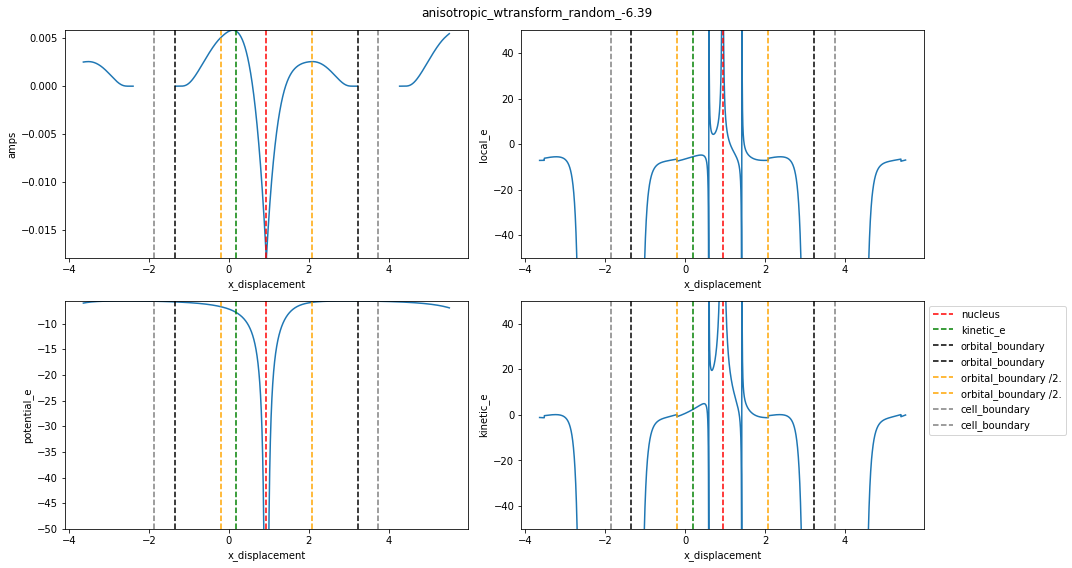

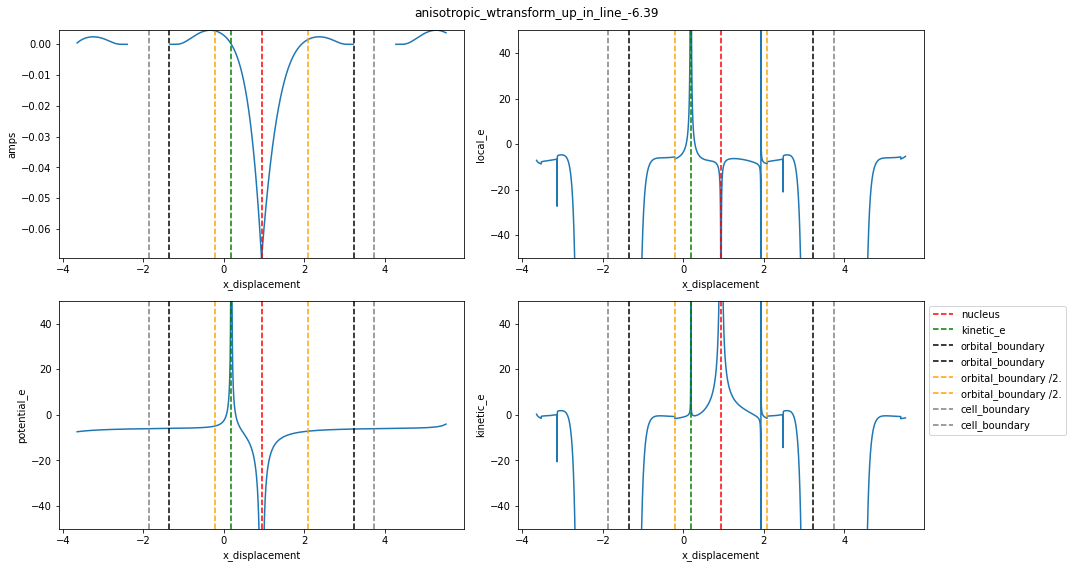

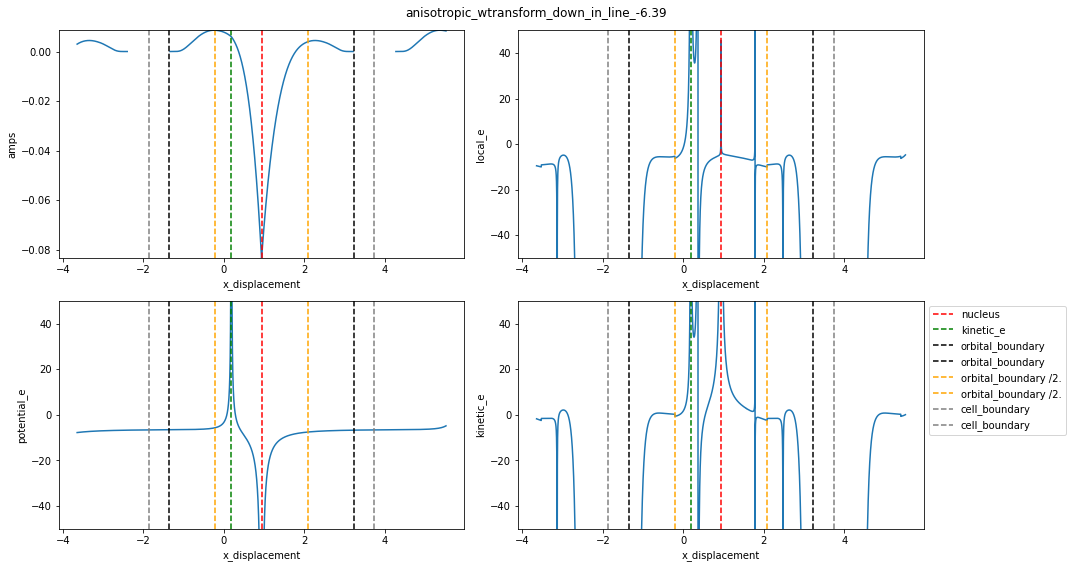

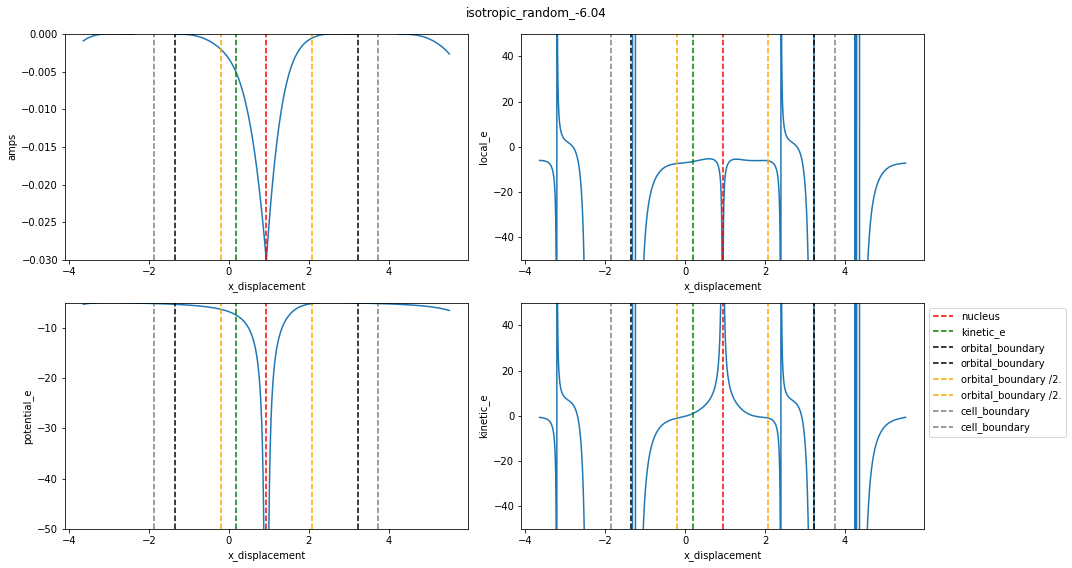

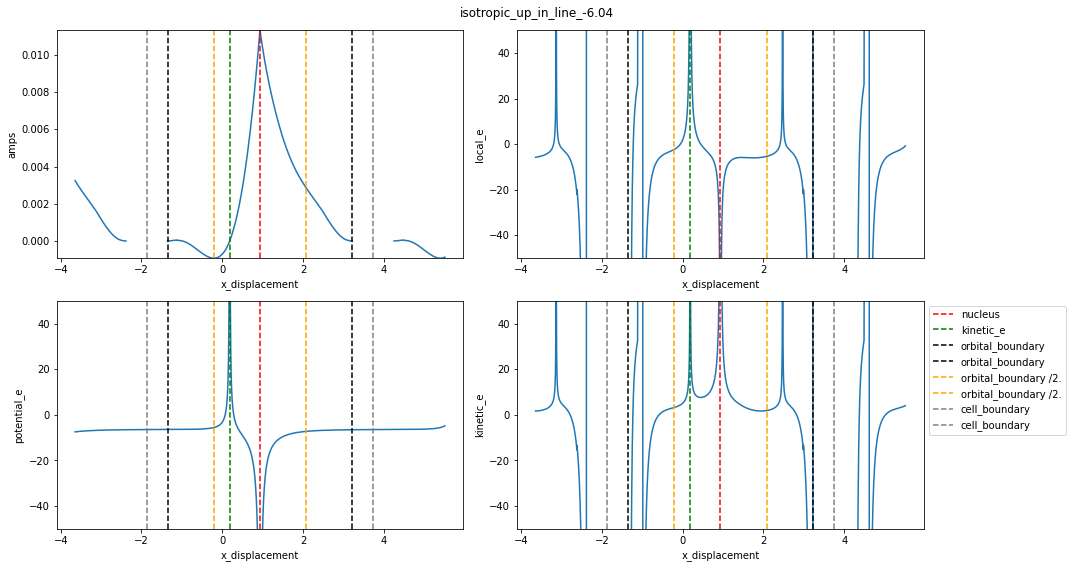

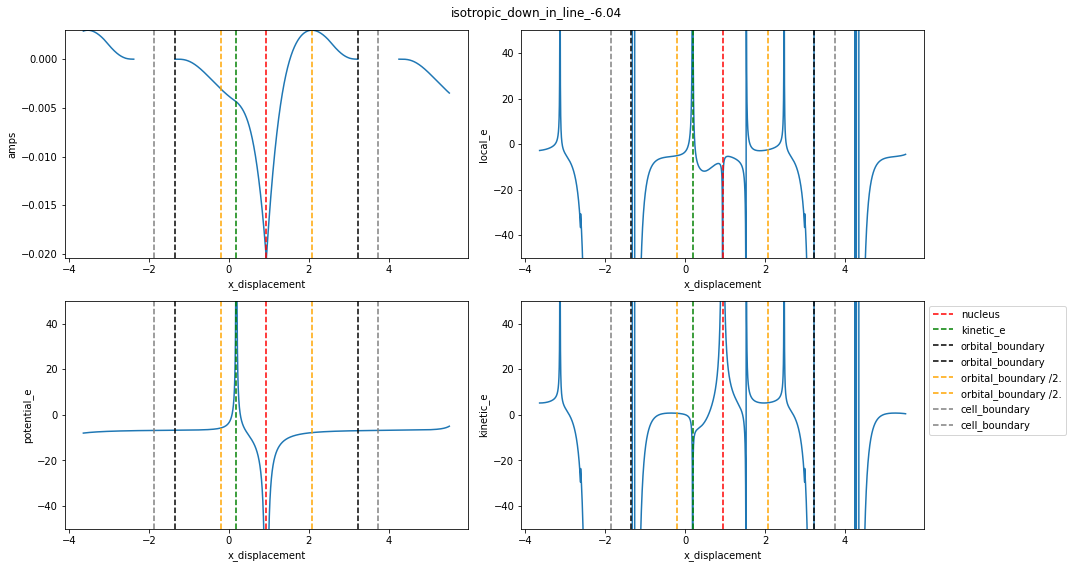

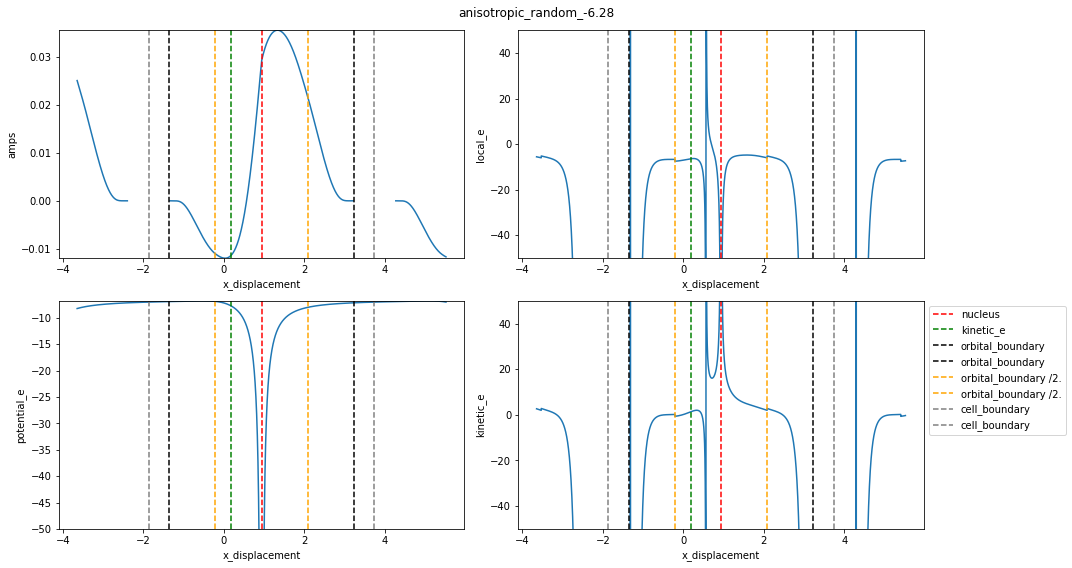

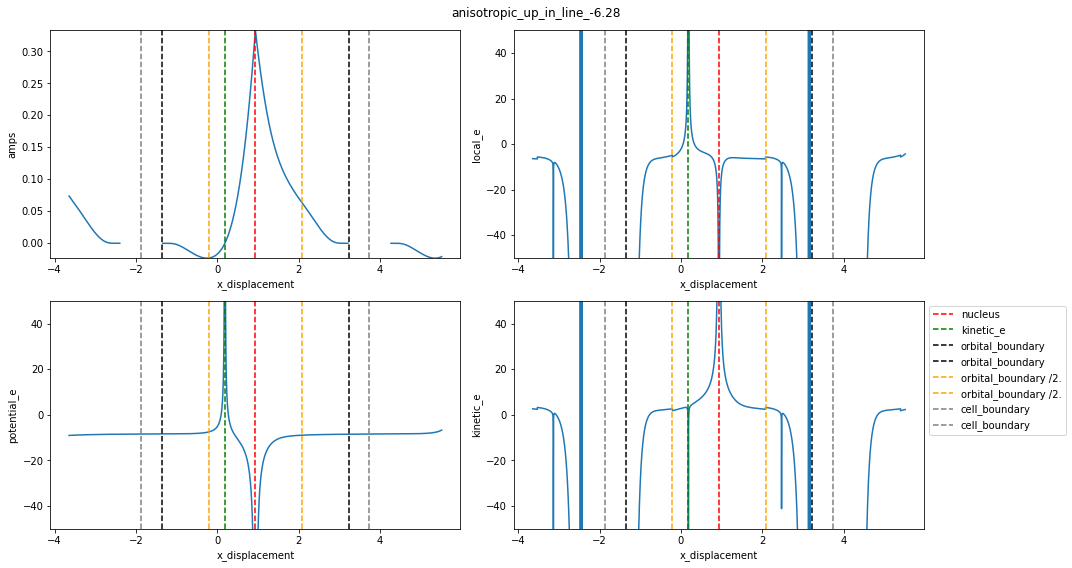

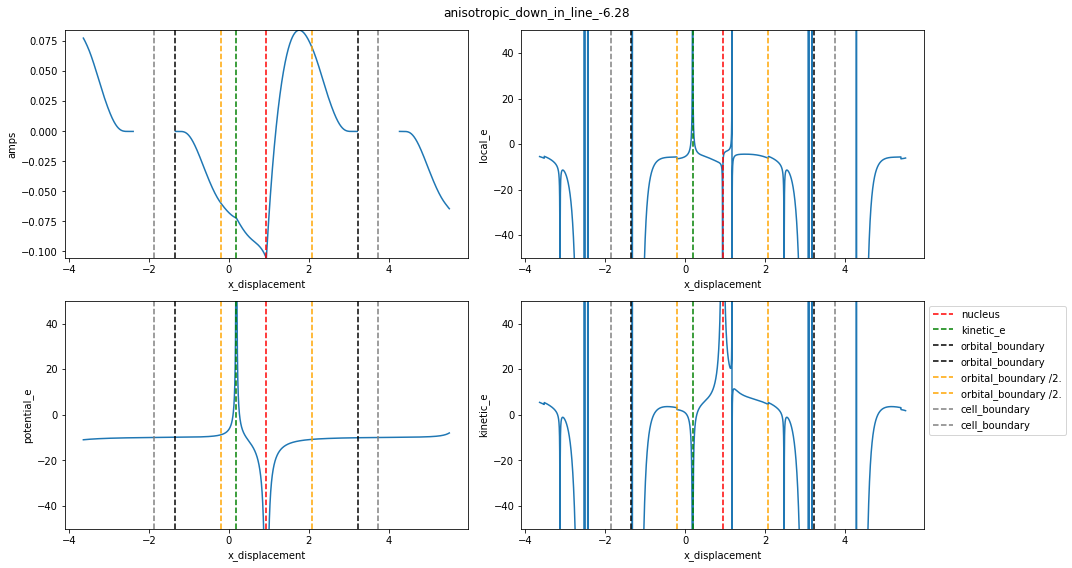

In [29]:
lim = 50
exps = ['anisotropic_wtransform', 'isotropic', 'anisotropic']
for exp in exps:
    final_e = od_datasets[exp]['e_mean_mean'][-1]
    for method in methods:
        data = save_data['%s_%s' % (exp, method)]
        plot_amps_and_energies(mol, data, ref, '%s_%s_%.2f' % (exp, method, final_e), lim)
plt.show()

In [11]:
# fix 2 and move the other across a slice that intersects with the atom also put the electrons in the same plane


mcw = mol.min_cell_width
ucw = mol.unit_cell_length
rx0, ry0, rz0 = mol.r_atoms[0]
n_samples = 1000
width = mcw
X = np.linspace(-width+rx0, width+rx0, n_samples)
Y = np.linspace(-width+ry0, width+ry0, n_samples)
XX, YY = np.meshgrid(X, Y)

x2, x3 = [float(np.random.normal(mol.r_atoms[0, 0], 0.1)) for i in range(2)]
y2, y3 = [float(np.random.normal(mol.r_atoms[0, 1], 0.1)) for i in range(2)]
z2, z3 = [float(np.random.normal(mol.r_atoms[0, 2], 0.1)) for i in range(2)]




def pbc(walkers, real_basis, inv_real_basis):
    talkers = walkers.dot(inv_real_basis)
    talkers = jnp.fmod(talkers, 1.)
    talkers = jnp.where(talkers < 0., talkers + 1., talkers)
    talkers = talkers.dot(real_basis)   
    return talkers

data_tmp = []
for x1 in X:
    walker = jnp.array([[[x1, ry0, rz0], [x2, y2, z2], [x3, y3, z3]]])

    walker = pbc(walker, mol.real_basis, mol.inv_real_basis)
    log_psi = jvwf(params, walker)
    
    local_energy = compute_energy(params, walker)
    tmp = [x1, float(walker[0, 0, 0]), local_energy, log_psi]
    data_tmp.append(tmp)

    


data = np.array(data_tmp)



plt.show()

ipykernel_launcher:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


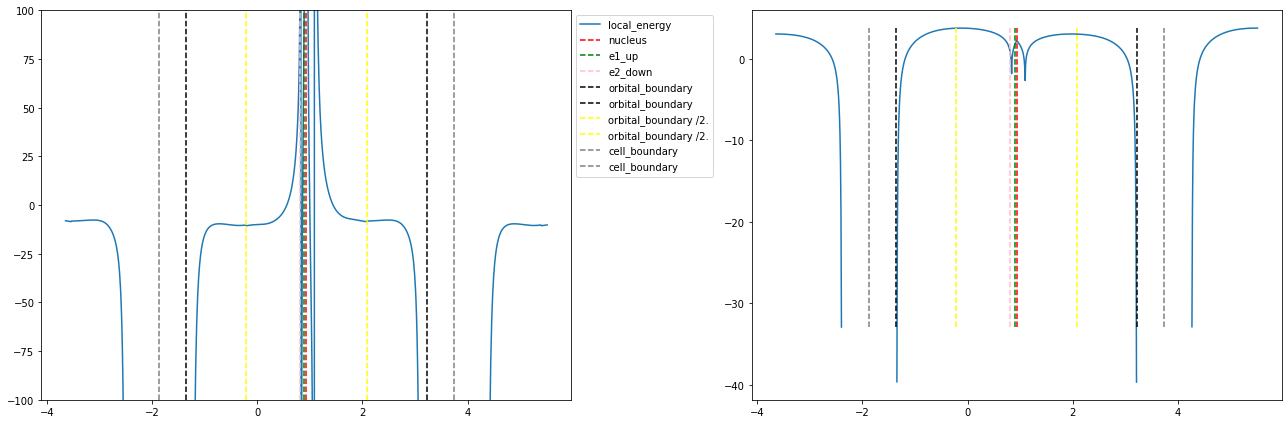

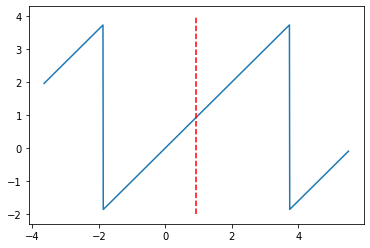

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# np.ma.masked_where(np.isnan(plot_data),plot_data)
energy_data = data[:, 2]
axs[0].plot(X, energy_data, label='local_energy')
ymax, ymin = energy_data.max(), energy_data.min()
ymax, ymin = 100, -100
y_line = np.linspace(ymin, ymax, 10)
axs[0].plot([rx0 for _ in y_line], y_line, color='r', ls='--', label='nucleus')
axs[0].plot([x2 for _ in y_line], y_line, color='g', ls='--', label='e1_up')
axs[0].plot([x3 for _ in y_line], y_line, color='pink', ls='--', label='e2_down')
axs[0].plot([rx0-mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')
axs[0].plot([rx0+mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')

axs[0].plot([rx0-mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')
axs[0].plot([rx0+mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')

axs[0].plot([rx0-ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')
axs[0].plot([rx0+ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')



axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")
axs[0].set_ylim(-100, 100)

ymax, ymin = data[:, -1].max(), data[:, -1].min()
y_line = np.linspace(ymin, ymax, 10)
axs[1].plot(X, data[:, -1])
axs[1].plot([rx0 for _ in y_line], y_line, color='r', ls='--', label='nucleus')
axs[1].plot([x2 for _ in y_line], y_line, color='g', ls='--', label='e1_up')
axs[1].plot([x3 for _ in y_line], y_line, color='pink', ls='--', label='e2_down')
axs[1].plot([rx0-mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')
axs[1].plot([rx0+mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')

axs[1].plot([rx0-mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')
axs[1].plot([rx0+mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')

axs[1].plot([rx0-ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')
axs[1].plot([rx0+ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')


fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1])
ymax, ymin = 4, -2
y_line = np.linspace(ymin, ymax, 10)
ax.plot([rx0 for _ in y_line], y_line, 'r--')



In [21]:
w1 = walker
translate = jnp.array([[[mol.unit_cell_length for _ in range(3)]]]).dot(mol.real_basis)
translate = jnp.array([[mol.real_basis[0, :]]])
w2 = pbc(walker+translate, mol.real_basis, mol.inv_real_basis)
print(w1 - w2)
print(jnp.linalg.norm(mol.real_basis, axis=-1))
print(mol.unit_cell_length)

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [4.7683716e-07 0.0000000e+00 0.0000000e+00]]]
[5.6081324 5.6081324 5.6081324]
5.608132296572055


In [29]:
# for i, x in enumerate(kinetic_energy):
    # print(x, i)
# 330
(vwalkers[330][None, ...] - mol.r_atoms[:, None, :]).dot(mol.inv_real_basis)

# do we get nans when we remove the minimum image convention? 

# do we get nans if we work around the sampling nans by substituting infs?  How does this affect the propagation of gradients? 

# should we be altering the inputs as well? 

DeviceArray([[[-0.02264956,  0.01108396, -0.38635388],
              [ 0.45481834,  0.18161534,  0.31698105],
              [-0.04993726, -0.04873225, -0.15789592]]], dtype=float32)

In [ ]:
# Only use the distances on the inputs

# displace the electrons along some path towards the nucleus for length L (should be periodic local energy)
mol = SystemAnsatz(**cfg)

vwf = create_wf(mol)



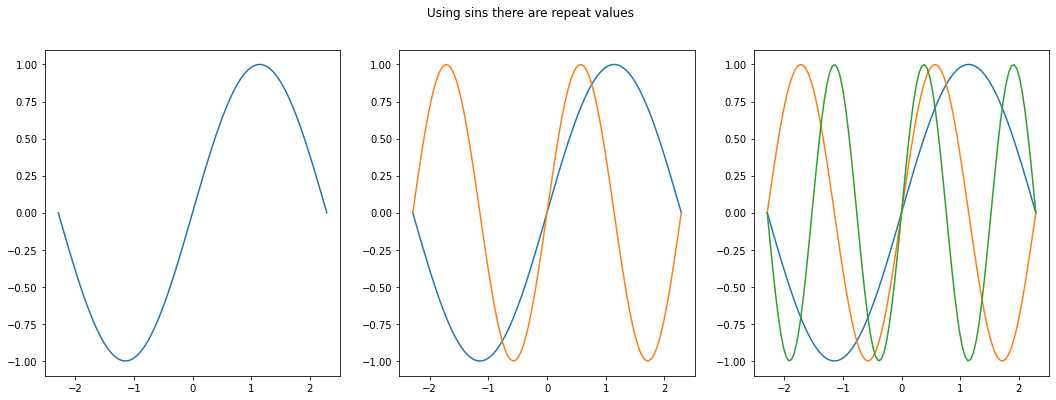

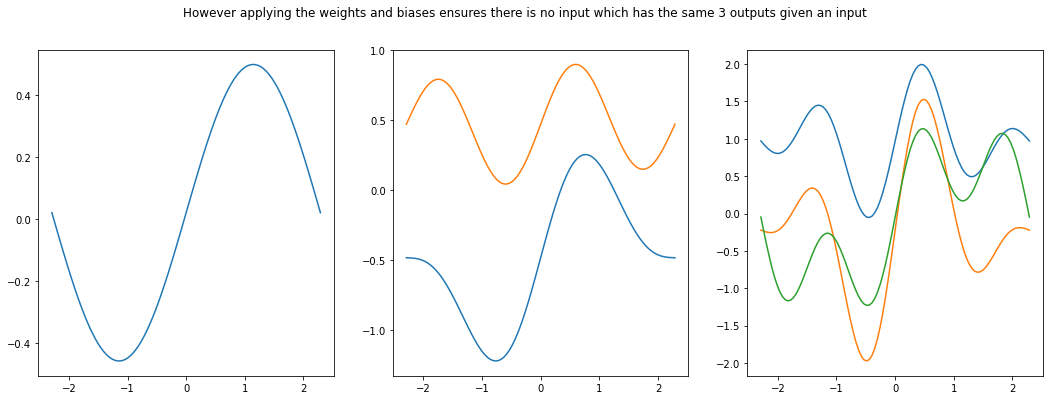

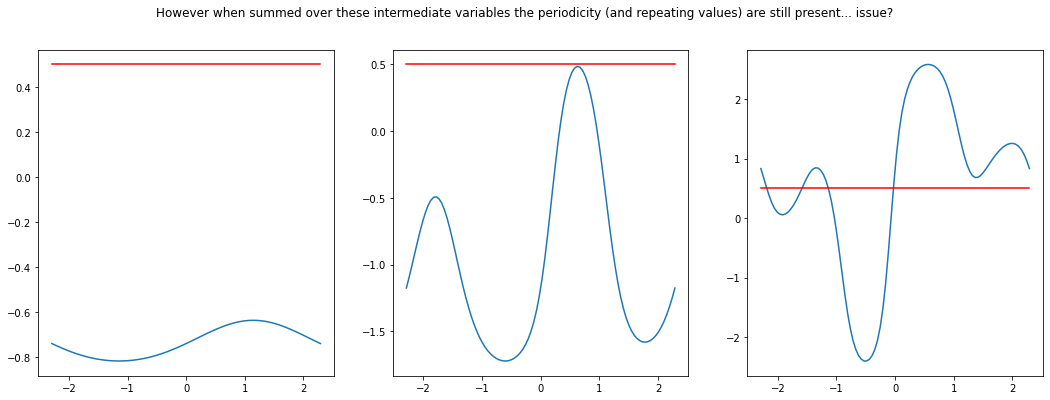

In [56]:
x = np.linspace(-mol.min_cell_width/2., mol.min_cell_width/2., 100)
n_sins = 4
w = np.random.uniform(0, 1, (n_sins, n_sins))

def sins(x, n_sins, L):
    return [np.sin((2.*i*np.pi/L) * x)[None, :] for i in range(1, n_sins+1)]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Using sins there are repeat values')
for ax, i in zip(axs, range(1, 4)):
    for y in sins(x, i, mol.min_cell_width):
        ax.plot(x, np.squeeze(y))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('However applying the weights and biases ensures there is no input which has the same 3 outputs given an input')
for ax, i in zip(axs, range(1, 4)):
    y = np.concatenate(sins(x, i, mol.min_cell_width), axis=0).T

    w = np.random.uniform(0, 1, (i, i))
    b = np.random.uniform(-1, 1, (i, 1))
    y = (y @ w).T + b
    for y_i in y:
        ax.plot(x, np.squeeze(y_i))


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('However when summed over these intermediate variables the periodicity (and repeating values) are still present... issue?')
for ax, i in zip(axs, range(1, 4)):
    y = np.concatenate(sins(x, i, mol.min_cell_width), axis=0).T

    w = np.random.uniform(0, 1, (i, i))
    b = np.random.uniform(-1, 1, (i, 1))
    y = (y @ w).T + b
    ax.plot(x, np.tanh(y).sum(axis=0))
    ax.plot(x, [0.5 for i in x], color='r')

plt.show()

In [87]:
# plot the various experiments

# - whoever is in town we could continue lunch on mondays



TypeError: array() missing required argument 'object' (pos 1)

In [ ]:
def plot_energies(method, dataset, lim=50):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        for ax, i, name in zip(axs, range(3, 6), ['local_energy', 'potential_energy', 'kinetic_energy']):
            y = dataset[:, i]
            ax.plot(X, y)
            y = np.clip(y, -lim, lim)
            ymax, ymin = np.nanmax(y), np.nanmin(y)
            plot_references(ax, method, ref, ymax=ymax, ymin=ymin)
            ax.set_ylabel(name)
            ax.set_xlabel('x_displacement')
            ax.set_ylim(ymin, ymax)

        axs[-1].legend(bbox_to_anchor=(1,1), loc="upper left")
        fig.suptitle('%s' % method)
        fig.tight_layout()

def plot_amps(method, ref):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    methods = ['amplitudes'] # 'probabilities
    for ax, i, name in zip(axs, range(1, 3), methods):
        y = datasets['amplitudes_%s' % method][:, i]
        ax.plot(X, y)
        y = np.clip(y, -lim, lim)
        ymax, ymin = np.nanmax(y), np.nanmin(y)
        plot_references(ax, method, ref, ymax=ymax, ymin=ymin)
        ax.set_ylabel(name)
        ax.set_xlabel('x_displacement')
        ax.set_ylim(ymin, ymax)

    axs[-1].legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.suptitle('%s' % method)
    fig.tight_layout()